# Date Type Image Classification Project

## Add dataset

In [1]:
ls '/kaggle/input/date-fruit-image-dataset-in-controlled-environment'


 Ajwa/     Medjool/  'Nabtat Ali'/   Shaishe/   Sugaey/
 Galaxy/   Meneifi/   Rutab/         Sokari/


## Import required libraries

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
print("tf versiyon:", tf.__version__)
import warnings
warnings.filterwarnings('ignore')

2025-05-16 18:52:01.838982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747421522.106123      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747421522.182725      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tf versiyon: 2.18.0


In [5]:
# Function to create a DataFrame from file paths and labels
# It goes into each folder, retrieves the file names, and stores them in the DataFrame

def create_dataset(folders, path):
    data = {'imgpath': [], 'labels': []}
    for folder in folders:
        folderpath = os.path.join(path, folder)
        files = os.listdir(folderpath)
        
        for file in files:
            filepath = os.path.join(folderpath, file)
            data['imgpath'].append(filepath)
            data['labels'].append(folder)

    dataset = pd.DataFrame(data)
    return dataset


In [6]:
# Create a DataFrame using the
path1 = '/kaggle/input/date-fruit-image-dataset-in-controlled-environment'
folders1 = ['Ajwa','Medjool', 'Nabtat Ali', 'Shaishe',   
            'Sugaey','Galaxy', 'Meneifi','Rutab','Sokari'] 
df = create_dataset(folders1, path1)
df.head()

,imgpath,labels
0,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
1,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
2,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
3,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa
4,/kaggle/input/date-fruit-image-dataset-in-cont...,Ajwa


In [7]:
# Dataset information
print('-- Dataset information --\n')
print(f'Number of images: {df.shape[0]}\n')
print(f'Number of labels: {len(df.labels.unique())}\n')
print(f'Labels: {df.labels.unique()}')

-- Dataset information --

Number of images: 1658

Number of labels: 9

Labels: ['Ajwa' 'Medjool' 'Nabtat Ali' 'Shaishe' 'Sugaey' 'Galaxy' 'Meneifi'
 'Rutab' 'Sokari']


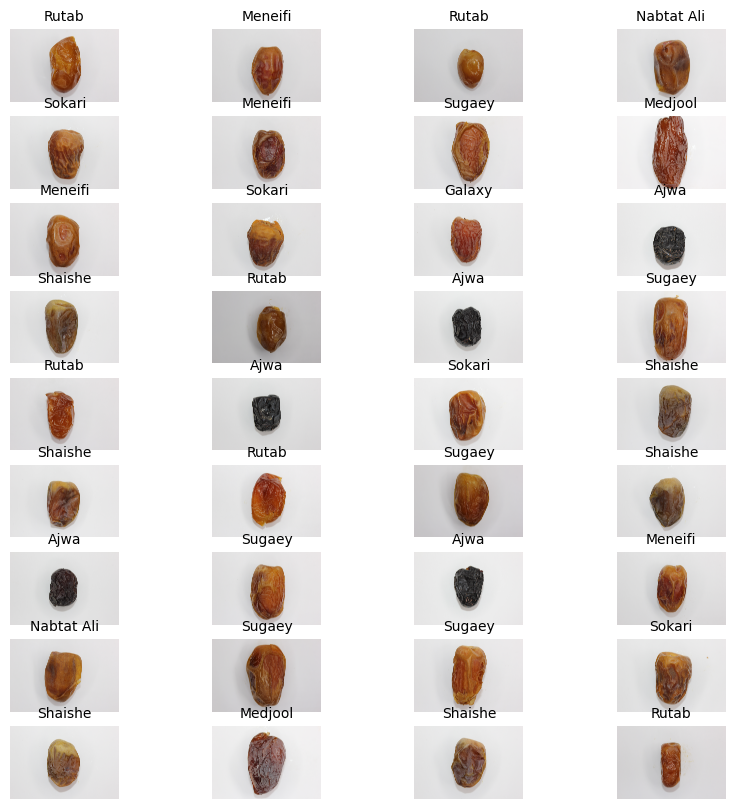

In [8]:
# Data Visualization
import random
import matplotlib.gridspec as gridspec
from PIL import Image
rows = 9
cols = 4

selected_indices = random.sample(range(len(df)), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (10, 10))
gs = gridspec.GridSpec(rows, cols, wspace = 0.0, hspace = 0.0)

for i, idx in enumerate(selected_indices):
    row = i // cols
    col = i % cols
    img_path = df['imgpath'].iloc[idx]
    label = df['labels'].iloc[idx]
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(label, fontsize = 10)

plt.show()

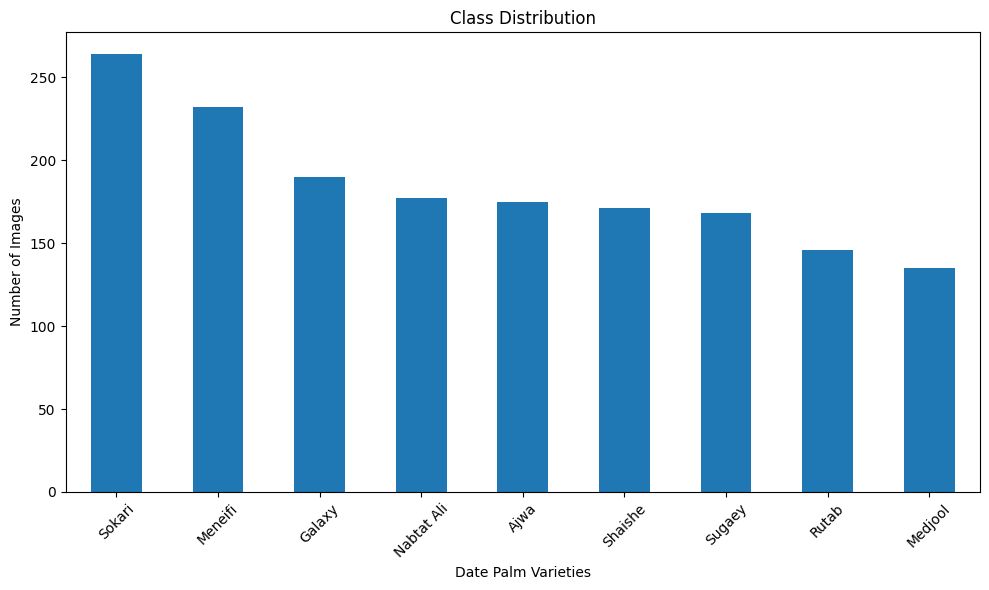

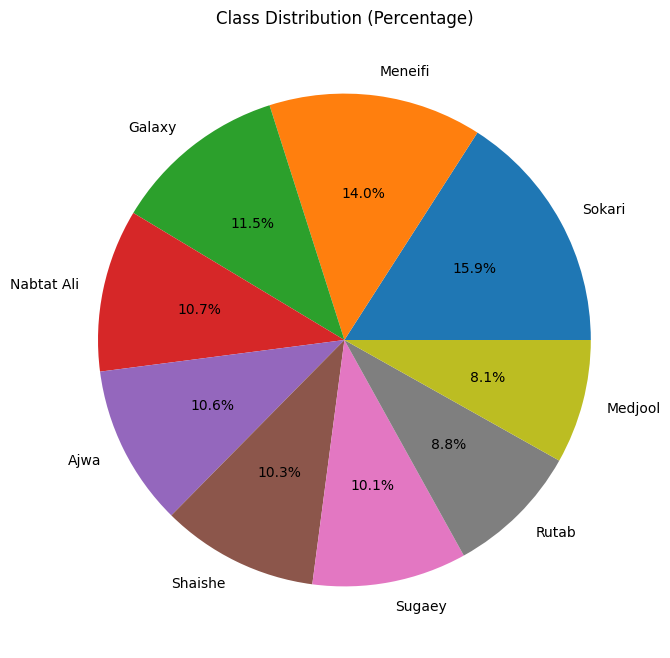

In [15]:
# Class distribution plot
plt.figure(figsize=(10, 6))
df.labels.value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Date Palm Varieties')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie plot label distribution
df.labels.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8))
plt.title('Class Distribution (Percentage)')
plt.ylabel('')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split

# Split the dataset using stratify by labels
# This way, the proportion of each class is preserved

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['labels'])

In [16]:
print(f"Training set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")

Training set size: 1326
Validation set size: 166
Test set size: 166


In [17]:
# DATA PREPROCESSING
# ImageDataGenerator - Converts image data into a format suitable for the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
seed = 42  # Fixed value for reproducibility
batch_size = 64  # Batch size to be used during training
img_size = (224, 224)  # Standard image size - model input size

In [18]:
# Generator that normalizes images to the 0-1 range
generator = ImageDataGenerator(rescale=1./255)

In [19]:
# Prepare training data
train_data = generator.flow_from_dataframe(
    train_df,  # DataFrame containing training data
    x_col='imgpath',  # Column containing image paths
    y_col='labels',  # Column containing labels
    color_mode='rgb',  # RGB color mode
    class_mode='categorical',  # For categorical labels
    batch_size=batch_size,
    target_size=img_size,  # Resize images
    shuffle=True,  # Shuffle training data
    seed=seed
)

Found 1326 validated image filenames belonging to 9 classes.


In [20]:
# Prepare validation data
val_data = generator.flow_from_dataframe(
    val_df,
    x_col = 'imgpath',
    y_col = 'labels',
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    target_size = img_size,
    shuffle = False  # Do not shuffle validation data
)

Found 166 validated image filenames belonging to 9 classes.


In [41]:
# Prepare test data
test_data = generator.flow_from_dataframe(
    test_df,
    x_col='imgpath',
    y_col='labels',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False  # Do not shuffle test data
)

Found 166 validated image filenames belonging to 9 classes.


In [21]:
# Get class names
class_names = list(train_data.class_indices.keys())
print(f"Classes: {class_names}")

# Model Creation - CNN (Convolutional Neural Network)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy

Classes: ['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


In [22]:
# Build CNN model
model = Sequential()

In [23]:
# Input layer - input shape 224x224 pixels, 3 channels - RGB
model.add(Input(shape=(224, 224, 3)))

In [24]:
# 1st Convolutional block
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))  # 32 filters, 3x3 kernel
model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsampling with 2x2 pooling

2025-05-16 18:58:51.376123: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [25]:
# 2nd Convolutional block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))  # 64 filters
model.add(MaxPooling2D(pool_size=(2, 2)))

In [26]:
# 3rd Convolutional block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))  # 128 filters
model.add(MaxPooling2D(pool_size=(2, 2)))

In [27]:
# 4th Convolutional block
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))  # 256 filters
model.add(MaxPooling2D(pool_size=(2, 2)))

In [28]:
# Flatten layer - converts 2D data to 1D
model.add(Flatten())

In [29]:
# Fully connected layer - 128 neurons
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # 50% dropout to prevent overfitting


In [30]:
# Output layer - 9 categories (number of date palm varieties)
model.add(Dense(9, activation='softmax'))

In [31]:
# Compile the model
# optimizer: Weight update algorithm
# loss: Loss function - suitable for categorical labels
# metrics: Metrics to monitor
model.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [32]:
# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,812,233 (25.99 MB)

 Trainable params: 6,812,233 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Model Training and Performance Monitoring
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Stop training at the lowest loss value and save the best model
model_es = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    mode='min',  # Stop at minimum value
    patience=5,  # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Restore best weights
    verbose=1
)

In [34]:
# Reduce learning rate on plateau
model_rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Reduce learning rate to 20%
    patience=3,  # If no improvement for 3 epochs
    mode='min',
    min_lr=1e-6,  # Minimum learning rate
    verbose=1
)

In [35]:
# Save the best model
checkpoint = ModelCheckpoint(
    'date_palm_model_best.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [36]:
# Train the model
history = model.fit(
    train_data,  # Training data
    validation_data=val_data,  # Validation data
    epochs=20,  # Maximum number of epochs
    callbacks=[model_es, model_rlr, checkpoint]  # Callbacks
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1111 - loss: 2.4734 
Epoch 1: val_accuracy improved from -inf to 0.16265, saving model to date_palm_model_best.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 256s 12s/step - accuracy: 0.1119 - loss: 2.4655 - val_accuracy: 0.1627 - val_loss: 2.1695 - learning_rate: 0.0010
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1766 - loss: 2.1464
Epoch 2: val_accuracy improved from 0.16265 to 0.21687, saving model to date_palm_model_best.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 192s 9s/step - accuracy: 0.1781 - loss: 2.1434 - val_accuracy: 0.2169 - val_loss: 1.8518 - learning_rate: 0.0010
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2573 - loss: 1.9347
Epoch 3: val_accuracy improved from 0.21687 to 0.29518, saving model to date_palm_model_best.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 193s 9s/step - accuracy: 0.2577 - loss: 1.9331 - val_accuracy: 0.2952 - val_loss: 1.9594 - learning_rate: 0.0010
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10

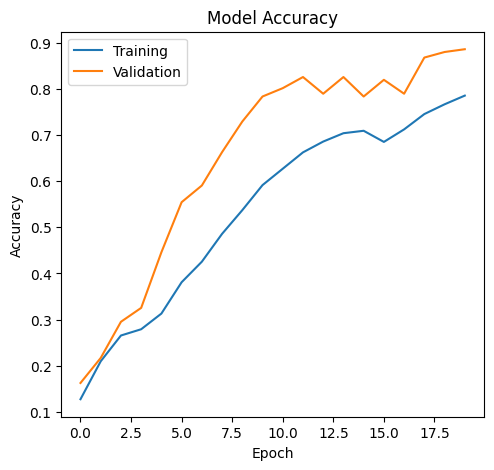

In [37]:
# Training history visualization
# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])

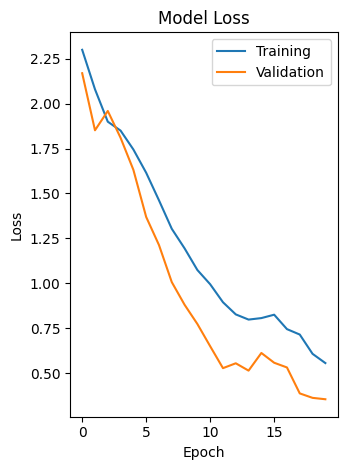

In [38]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])

plt.tight_layout()
plt.show()

In [39]:
# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [42]:
# Evaluation on test data
test_results = model.evaluate(test_data, verbose=1)
print(f'\nTest Loss: {test_results[0]:.5f}')
print(f'Test Accuracy: {test_results[1]*100:.2f}%')

3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.8242 - loss: 0.3921

Test Loss: 0.36085
Test Accuracy: 85.54%


In [43]:
# Calculate predictions
y_pred_prob = model.predict(test_data)
y_pred = np.argmax(y_pred_prob, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step


In [45]:
# Get true labels
y_true = test_data.classes

In [46]:
# Classification report - detailed metrics
class_report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names, 
    output_dict=True
)

In [47]:
# Convert to DataFrame and display
report_df = pd.DataFrame(class_report).transpose()
print("\nClassification Report:")
print(report_df)


Classification Report:
              precision    recall  f1-score     support
Ajwa           1.000000  1.000000  1.000000   17.000000
Galaxy         0.818182  0.947368  0.878049   19.000000
Medjool        0.923077  0.857143  0.888889   14.000000
Meneifi        0.875000  0.875000  0.875000   24.000000
Nabtat Ali     0.812500  0.764706  0.787879   17.000000
Rutab          0.823529  0.933333  0.875000   15.000000
Shaishe        0.923077  0.705882  0.800000   17.000000
Sokari         0.920000  0.884615  0.901961   26.000000
Sugaey         0.631579  0.705882  0.666667   17.000000
accuracy       0.855422  0.855422  0.855422    0.855422
macro avg      0.858549  0.852659  0.852605  166.000000
weighted avg   0.861344  0.855422  0.855606  166.000000


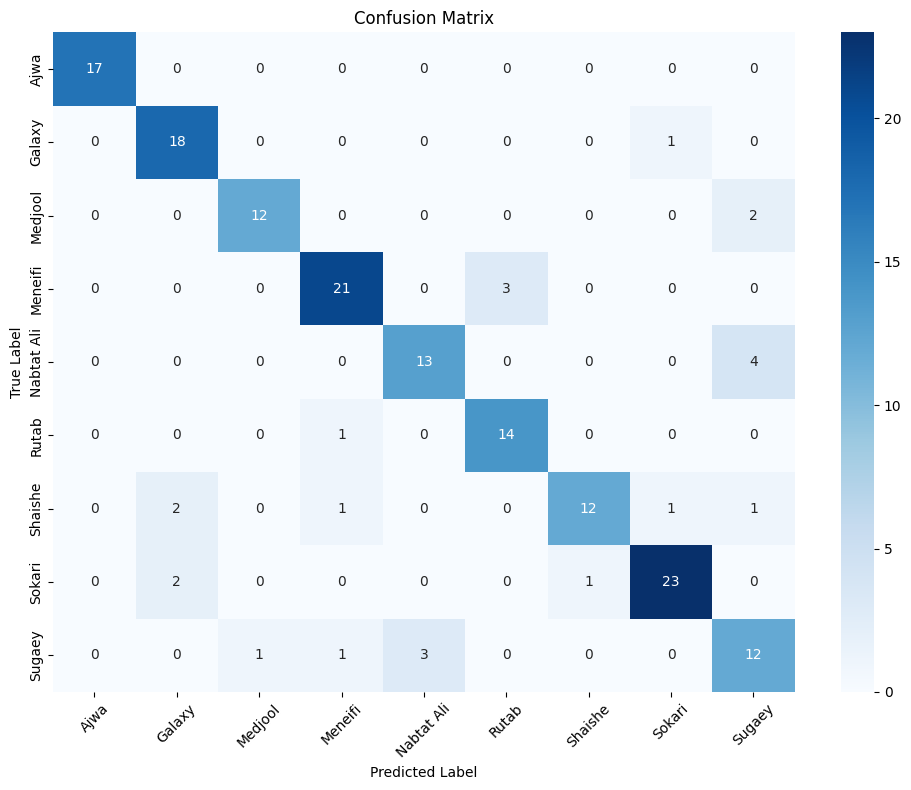

In [48]:
# Confusion Matrix - which classes are confused
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [49]:
# ROC curves and AUC calculation
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [50]:
# Convert labels to binary format (one-hot encoding)
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

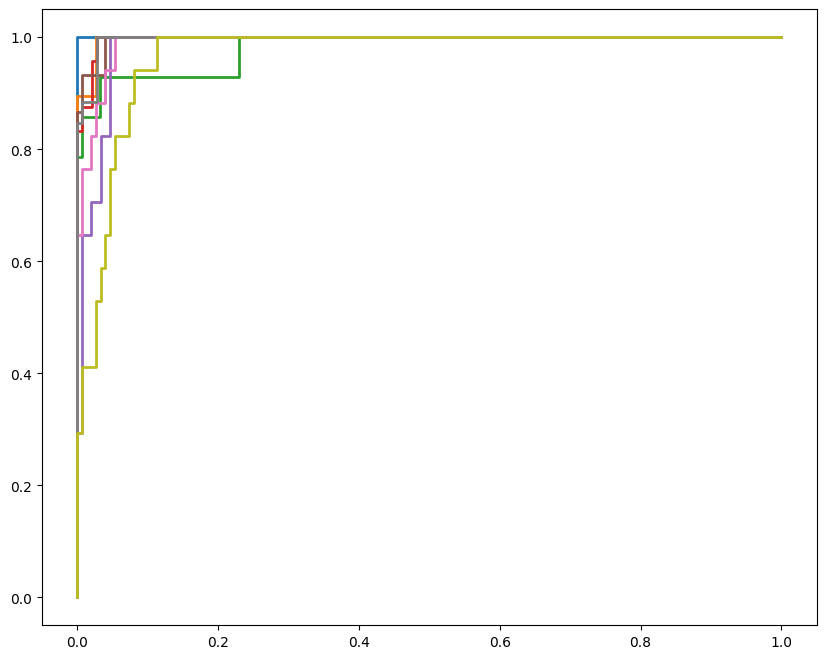

In [51]:
# Calculate ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

In [53]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve, average_precision_score

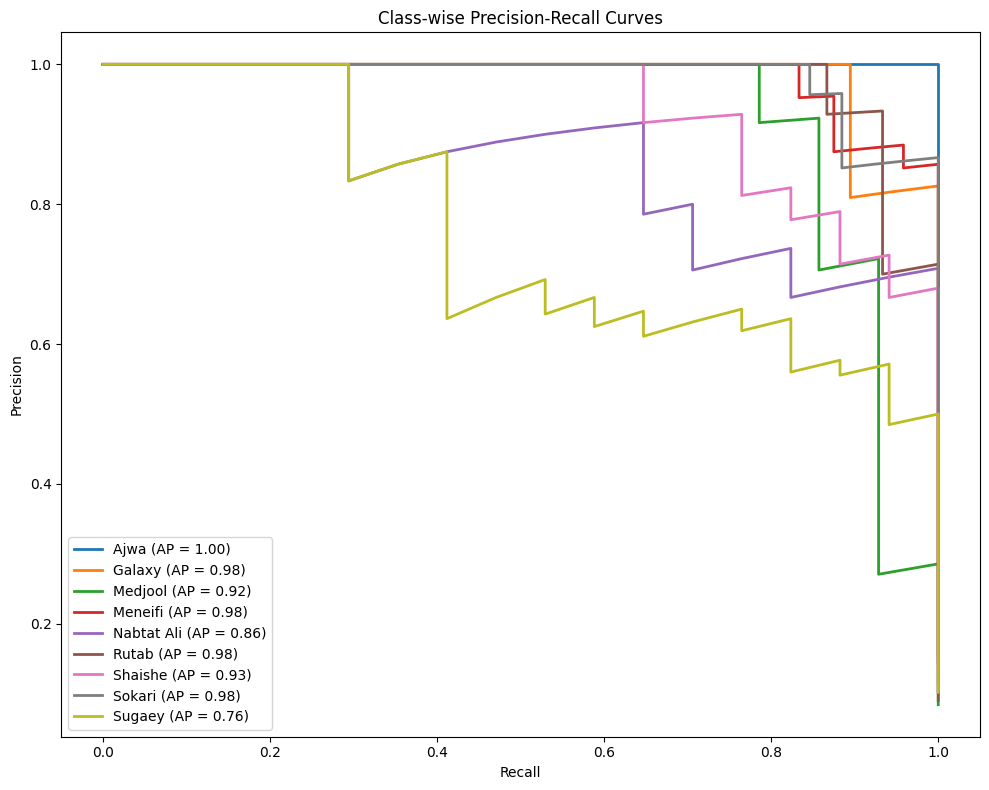

In [54]:
# Precision-Recall curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
    
    plt.plot(recall, precision, lw=2,
             label=f'{class_names[i]} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Class-wise Precision-Recall Curves')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

In [59]:
# Evaluate random test samples
plot_predictions(model, test_data, class_names, num_samples=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


In [60]:
# Save the model
model.save('date_classification_model.h5')
print("\nModel saved: date_classification_model.h5")


Model saved: date_classification_model.h5


In [61]:
# Example code showing how to use the model
def predict_image(model, img_path, class_names):
    """
    Classify a single image
    """
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model.predict(img_array)
    pred_class = np.argmax(prediction, axis=1)[0]
    pred_prob = np.max(prediction)
    
    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[pred_class]}\nProbability: {pred_prob:.2f}")
    plt.axis('off')
    plt.show()
    
    return class_names[pred_class], pred_prob

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


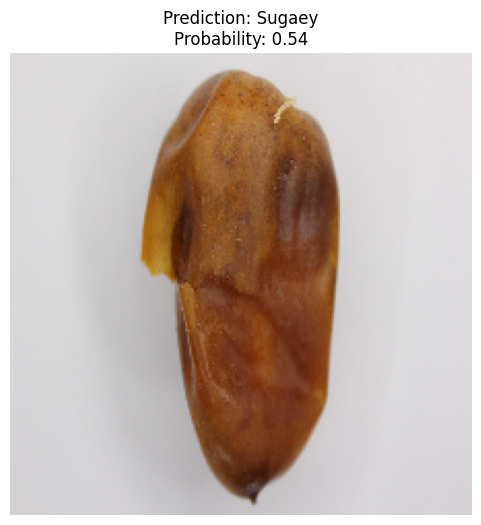

Predicted class: Sugaey, Probability: 0.54


In [62]:
# Select an image from the test set
sample_img_path = test_df['imgpath'].iloc[0]
pred_class, pred_prob = predict_image(model, sample_img_path, class_names)
print(f"Predicted class: {pred_class}, Probability: {pred_prob:.2f}")

In [63]:
# Project completed!
print(f"\nProject completed! The model was successfully trained with {test_results[1]*100:.2f}% accuracy.")


Project completed! The model was successfully trained with 85.54% accuracy.


In [64]:
# Summary
print("\n--- PROJECT SUMMARY ---")
print(f"Total number of images: {df.shape[0]}")
print(f"Total number of classes: {len(class_names)}")
print(f"Training set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")
print(f"Model accuracy: {test_results[1]*100:.2f}%")
print("----------------------")


--- PROJECT SUMMARY ---
Total number of images: 1658
Total number of classes: 9
Training set size: 1326
Validation set size: 166
Test set size: 166
Model accuracy: 85.54%
----------------------
